In [1]:
import numpy as np
import pandas as pd

from pymongo import MongoClient
import pprint

import nltk
import spacy
import string
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from nltk.corpus import stopwords 
punctuations = string.punctuation

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF

import pyLDAvis, pyLDAvis.sklearn
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
nlp = spacy.load('en')

def spacy_tokenizer(sentence):
    
    '''Tokenizes text dats to 'bag of words' by changing upper case words to lower case except for proper nouns,
    and removing punctuation and stop words.
    
    ''' 
    stop_words = set( stopwords.words('english') ).union( set(ENGLISH_STOP_WORDS) )
    symbols = punctuations + '≥, ≤, ∞, −oh, ™, ’, €, …, •, “, ’s, ’80, ’50s'
    
    tokens = nlp(sentence)
    tokens = [tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_ for tok in tokens]
    tokens = [tok for tok in tokens if (tok not in stop_words and tok not in symbols)]     
    return tokens

In [3]:
def vectorize_and_model(vectorizer, model, text):
    
    '''Vectorizes text data via input vectorizer and runs input model on vectorized text
    
    Requires vectorizer, model and text data as input parameters'''
    
    X = vectorizer.fit_transform(text)
    return model.fit_transform(X)

In [4]:
def display_topics(model, feature_names, no_top_words):
    
    '''Displays topic vocabulary words (number of words defined by "no_top_words" parameter) for model selected.
    
    Requires model, feature_names(from vecotizer) and number of top words as input parmeters'''
    
    for ix, topic in enumerate(model.components_):
        print("Topic ", ix+1)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

### Read Text Data

In [5]:
# Open Mongo client
client= MongoClient()
db = client.adhesives
articles_collection = db.articles

In [6]:
# Read text corpora from Mongo
articles_text = []
for record in articles_collection.find():
    articles_text.append(record['text_body'])                            

In [7]:
articles_text[596]

'\nQuestion: We have been making two-part epoxy putty compound in a northern climate, where it’s hot from April through mid-October and bitterly cold from October to February. Many times in the winter, we have had crystallization problem in part-A (epoxy side) of the sealant. We have studied a lot of literature and information on this but have not yet come up with a solution. We have considered mixing bis-A and bis-F resins. Can you help? \n\t\xa0 \nAnswer: I have been asked this question quite a few times in the past (see my column in the September 2005 issue of ASI). The short-term solution to this problem is to store your epoxies at temperatures above ambient. However, the root cause of your problem is that epoxy resins are super-cooled liquids at normal temperature and tend to crystallize. The worst situation is where you use a low-molecular-weight, very high-purity resin; this has a high propensity to crystallize. \n\tI have explored several approaches to this problem, and mixing 

### NMF Analysis

In [8]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),  
                                   tokenizer=spacy_tokenizer,
                                   max_df=0.6,
                                   min_df = 2)

nmf = NMF(n_components=100, random_state=42)
          # , alpha=.1, l1_ratio=.5)

### View Model Output

In [9]:
nmf_data = vectorize_and_model(tfidf_vectorizer, nmf, articles_text)

In [10]:
nmf_data.shape

(597, 100)

In [11]:
display_topics(nmf,tfidf_vectorizer.get_feature_names(),20)

Topic  1
erp inventory butler process datum wireless software management time business real time implementation need real cost manage customer decision manufacturer control
Topic  2
raw raw material supplier customer regulatory innovation supply market industry global chain price regulation material supplier value chain cost economy sustainability chemical need
Topic  3
year view website post asi website view post view date website post story asi view feature article asi feature article view 1/1/15 1/1/15 1/1/15 date story asi article year 1/1/14
Topic  4
handbook material chemical supplier additive handbook polymer additive chemical polymer material supplier raw material raw 248 786 786 248 additive chemical hurley 248 1662 hurleys@bnpmedia.com 1662 786 1662 contact definition
Topic  5
asc convention course short course expo keynote schedule session short tuesday program attendee april wednesday lunch event convention expo member industry president
Topic  6
coating april american coat

In [12]:
nmf_data

array([[0.        , 0.        , 0.0001336 , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.0002585 , ..., 0.00024751, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [13]:
nmf_data.sum(axis=1)

array([0.41654804, 0.25303688, 0.12728681, 0.43291388, 0.38923295,
       0.41877747, 0.36781431, 0.18727927, 0.15144368, 0.44375529,
       0.24686012, 0.43291388, 0.15345559, 0.28111247, 0.29827436,
       0.59995217, 0.13831812, 0.17188846, 0.22368989, 0.27483552,
       0.19963674, 0.11425766, 0.14991981, 0.32171785, 0.4378118 ,
       0.4367461 , 0.76434349, 0.25438516, 0.14814856, 0.21213542,
       0.7386628 , 0.20508558, 0.5553783 , 0.41297995, 0.18642248,
       0.2233513 , 0.48181706, 0.34238245, 0.19399273, 0.30736077,
       0.62957215, 0.77023467, 0.29599667, 0.16187095, 0.25946397,
       0.47311835, 0.04423624, 0.20549147, 0.13512091, 0.19968945,
       0.37004222, 0.11793555, 0.364315  , 0.17586401, 0.38900964,
       0.11730796, 0.25550936, 0.0903604 , 0.20217876, 0.43490622,
       0.34351535, 0.41911255, 0.43069154, 0.28278657, 0.22524486,
       0.35240235, 0.79537908, 0.31237567, 0.43942084, 0.29740156,
       0.36781431, 0.2775456 , 0.51575663, 0.48881062, 0.54734

### Graphical Topic Analysis

In [14]:
# Noramlize topic importances by document and convert to dataframe
df_topic_importances = pd.DataFrame(nmf_data/nmf_data.sum(axis=1).reshape(-1,1))
df_topic_importances.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.0,0.0,0.000321,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# Read document data from mongo into dataframe to access document publication date and title
cursor = articles_collection.find()
df_articles = pd.DataFrame(list(cursor))
df_articles.drop('text_body', axis=1, inplace=True)
df_articles.tail()

,_id,author,date,title
592,5b8ad0c38f01c9eefed2a1e4,staff,"January 2, 2014","Case Study: Corrugated Converter ""Sticks It"" t..."
593,5b8ad0c58f01c9eefed2a1e5,Mark Collatz,"July 1, 2016","At Long Last, TSCA Reform Passes"
594,5b8ad0c78f01c9eefed2a1e6,staff,"November 1, 2014",Improving Customer Care
595,5b8ad0c88f01c9eefed2a1e7,staff,"October 1, 2013",Product Profile: Static Mixers
596,5b8ad0c98f01c9eefed2a1e8,staff,"December 11, 2014",Ask Dr. Dave: Can you help us with a crystalli...


In [16]:
# Merge topic importance and document information dataframes to support plotting importances by date
df_articles_topics = pd.merge(df_articles, df_topic_importances, right_index=True, left_index=True)
df_articles_topics.head()

,_id,author,date,title,0,1,2,3,4,5,...,90,91,92,93,94,95,96,97,98,99
0,5b8acb9a8f01c9eefed29f94,staff,"August 10, 2018",Applying Rapid-Cure Adhesives with a Meter/Mix...,0.0,0.0,0.000321,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5b8acb9c8f01c9eefed29f95,staff,"August 10, 2018",Industry Leaders to Gather at ASC Executive Le...,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5b8acb9e8f01c9eefed29f96,staff,"August 10, 2018",Evaluating Adhesive Options in Packaging Appli...,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5b8acba18f01c9eefed29f97,staff,"August 8, 2018",3M Sales Rise 7% in Second Quarter 2018,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5b8acba48f01c9eefed29f98,staff,"August 21, 2018",Sika Automotive Receives Product Leadership Award,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
# Convert date value type to datetime to time grouping
df_articles_topics['date'] = pd.to_datetime(df_articles_topics['date'],infer_datetime_format=True)
df_articles_topics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 597 entries, 0 to 596
Columns: 104 entries, _id to 99
dtypes: datetime64[ns](1), float64(100), object(3)
memory usage: 485.1+ KB


/Users/ericwk/anaconda/lib/python3.6/site-packages/dateutil/parser/__init__.py:46: DeprecationWarning: _timelex is a private class and may break without warning, it will be moved and or renamed in future versions.
  warnings.warn(msg, DeprecationWarning)


In [18]:
# Drop article with date before 2013
df_articles_topics = df_articles_topics[df_articles_topics['date'] > '1-1-2013']

In [19]:
# Drop columns not needed for plotting
df_date_topics = df_articles_topics.drop(['_id', 'author', 'title'], axis=1)

In [20]:
# Convert date to 'year-month' string
df_date_topics['year-month'] = df_date_topics['date'].apply(lambda x: str(x.year) + ' ' + str(x.month))

In [21]:
# Group documents by 'year-month' and sum topic importances for each topic
df_grouped_month = df_date_topics.groupby(['year-month']).sum()

In [22]:
df_grouped_month

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
year-month,,,,,,,,,,,,,,,,,,,,,
2013 10,0.000000,0.013050,0.001742,0.012002,0.052314,0.024338,0.000000,0.078709,0.250266,0.003991,...,0.139474,0.337485,0.000000,0.967989,0.119393,0.336085,0.012090,0.560193,0.152646,0.354722
2013 11,0.013329,0.091683,0.000000,0.025485,0.000000,0.000272,0.205613,0.187185,0.033259,0.016924,...,0.048363,0.123537,0.001971,0.038163,0.491257,0.669405,0.334154,1.650898,0.107139,0.114341
2013 12,0.000000,0.000255,0.115505,0.000000,0.004635,0.000000,0.004038,0.000955,0.000000,0.000243,...,0.009219,0.000000,0.979824,0.018460,0.000000,0.000000,0.000958,0.000000,0.003972,0.000000
2013 9,0.776560,0.078091,0.027327,0.039087,0.601827,0.009084,0.244488,0.307486,0.005981,0.005455,...,0.011033,0.700903,0.376142,0.016647,0.111869,0.053320,0.067782,0.116716,0.631055,0.100351
2014 1,0.005181,0.000000,0.000426,0.007709,0.004994,0.000000,0.000000,0.162988,0.000201,0.009958,...,0.000000,0.007086,0.000000,0.052207,0.041943,0.012146,0.955731,0.001806,0.000000,0.029701
2014 10,0.039924,0.028309,0.047507,0.056612,0.062866,0.024673,0.349413,0.066886,0.248704,0.000000,...,0.079925,0.053394,0.000462,0.612325,0.522727,0.179492,0.134115,0.346270,0.131924,0.280134
2014 11,0.012886,0.061155,0.008200,0.018534,0.026018,0.003512,0.222711,0.464465,0.682878,0.011451,...,0.946519,0.327988,0.309901,0.073576,0.254983,0.080598,0.663151,1.019595,0.080388,0.307102
2014 12,0.000000,0.000000,2.831360,0.029823,0.001201,0.005289,0.230839,0.001361,0.000000,0.001928,...,0.006208,0.000000,0.001696,0.000000,0.000000,0.000000,0.003010,0.001093,0.000000,0.000000
2014 2,0.000000,0.324618,0.000156,1.001044,0.011285,0.012043,0.027993,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.019980,0.521052,0.000000,0.000000,0.000000,0.263138,0.026999,0.004498


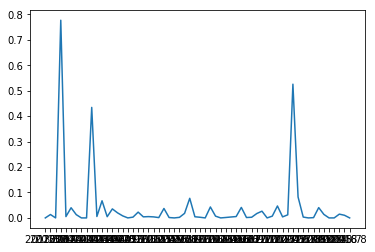

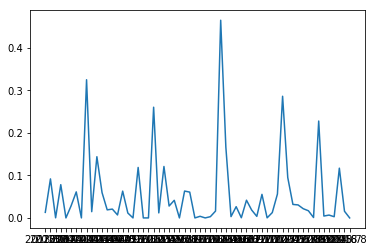

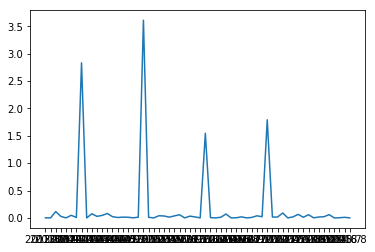

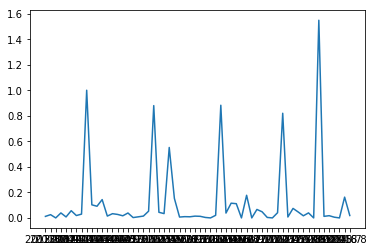

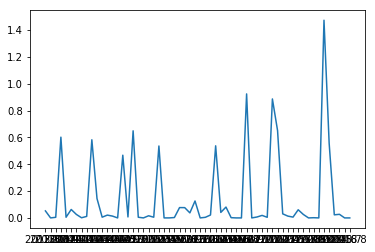

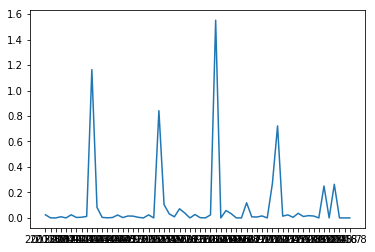

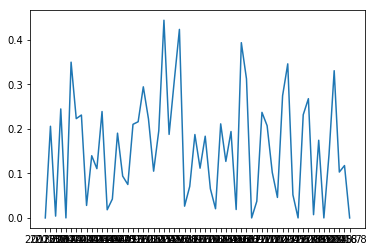

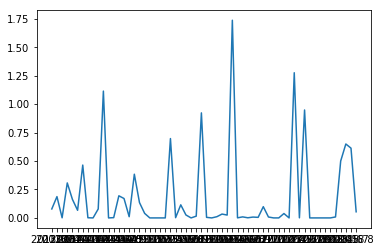

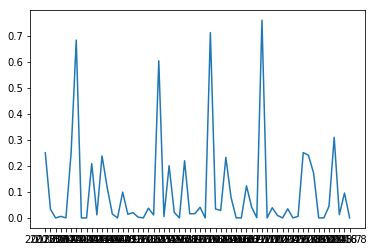

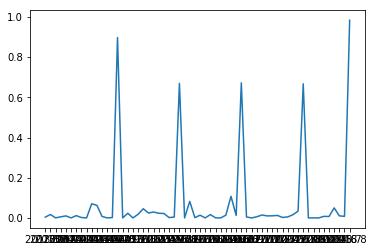

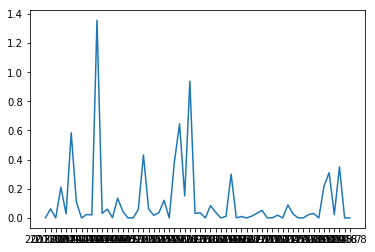

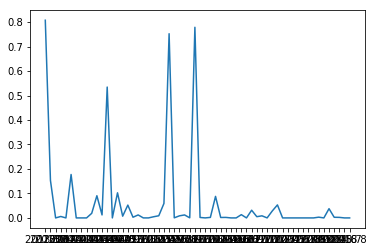

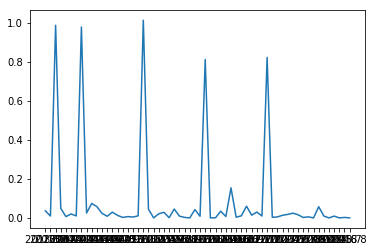

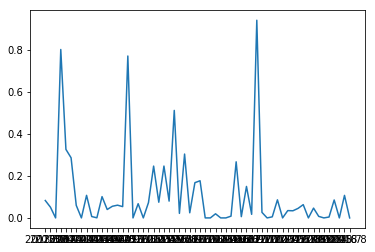

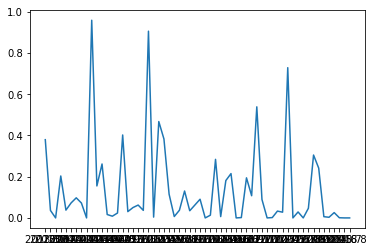

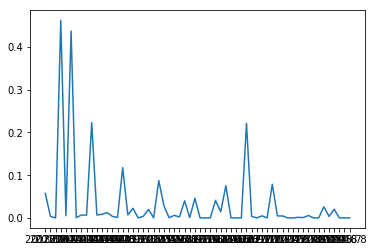

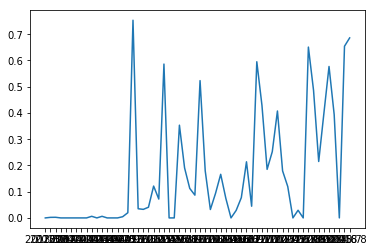

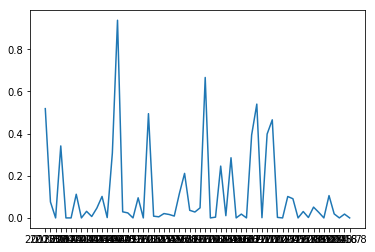

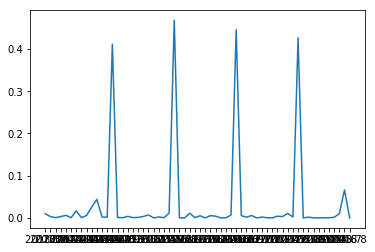

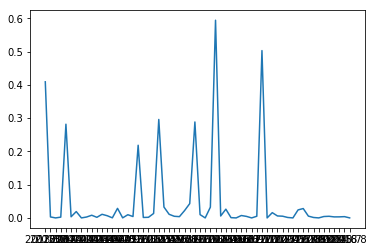

In [23]:
# Plot topic importance versus 'year-month'
for col in range(0, 20):
    plt.figure()
    plt.plot(df_grouped_month[col])

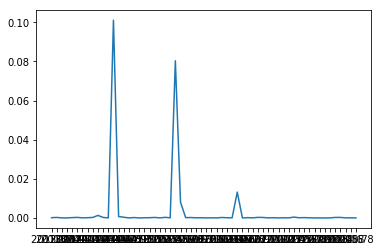

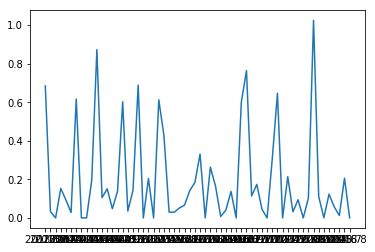

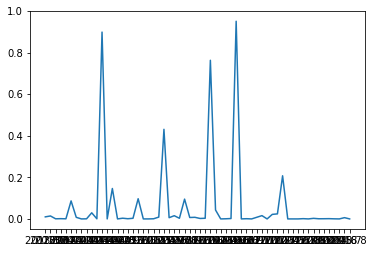

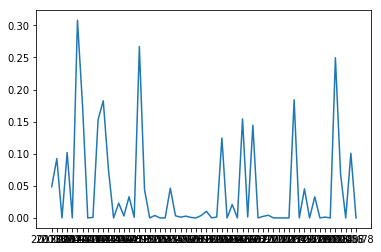

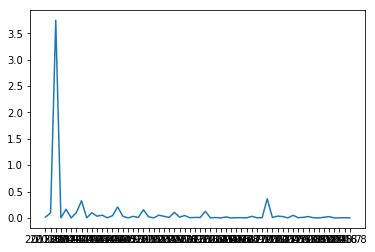

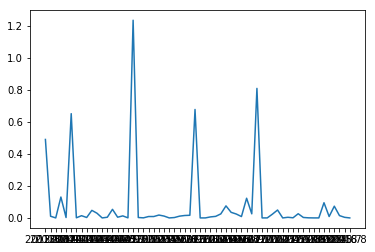

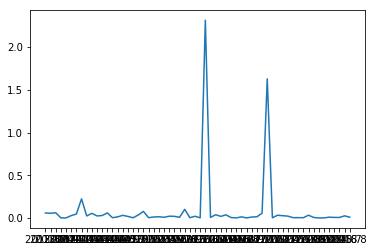

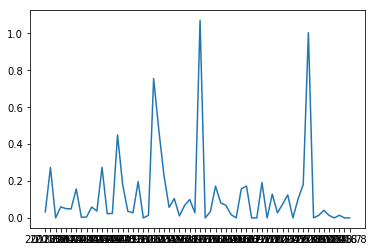

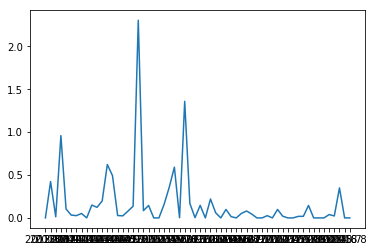

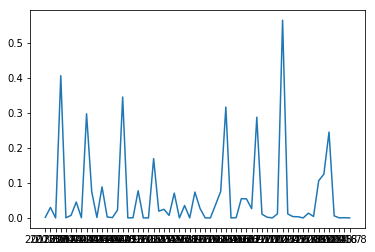

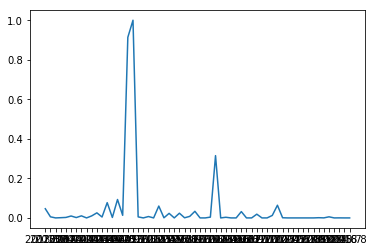

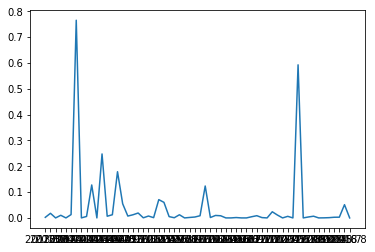

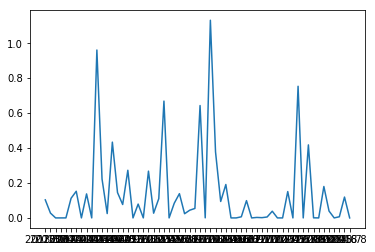

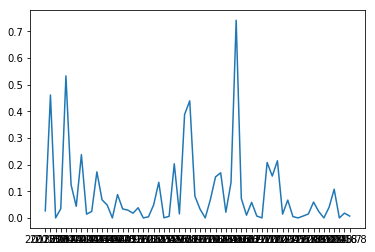

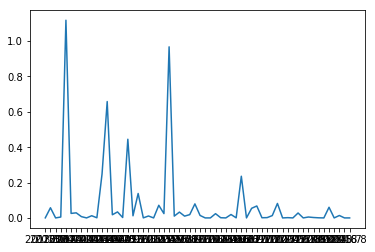

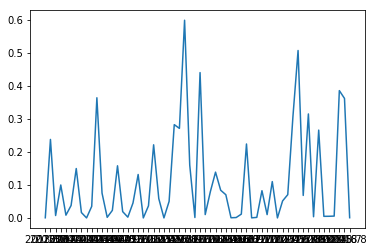

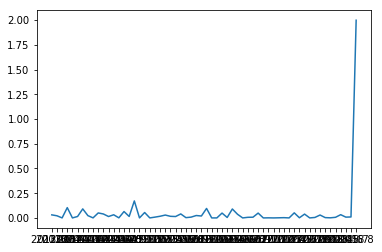

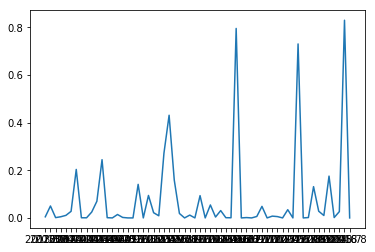

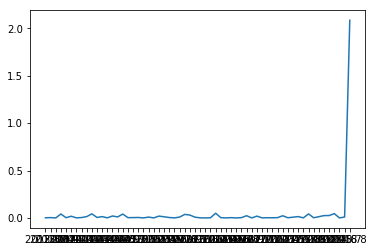

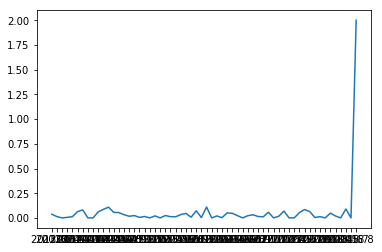

In [24]:
for col in range(20, 40):
    plt.figure()
    plt.plot(df_grouped_month[col])

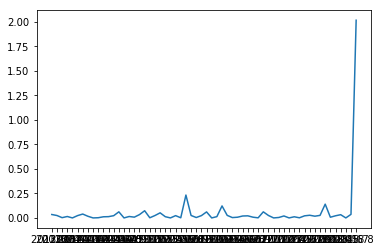

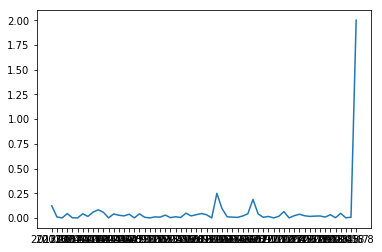

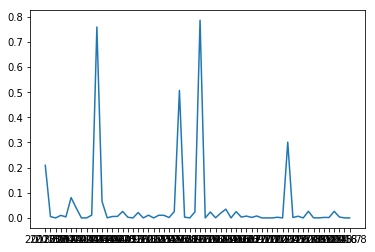

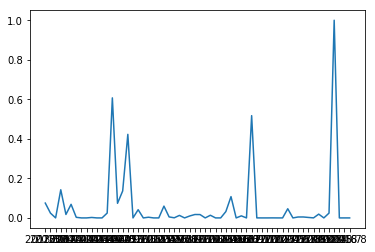

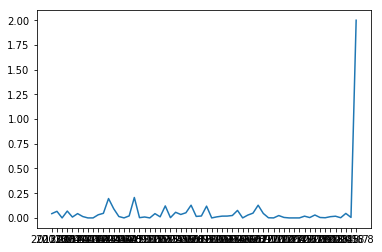

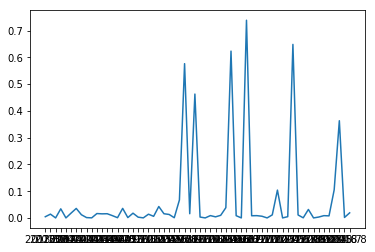

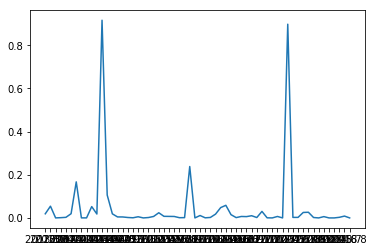

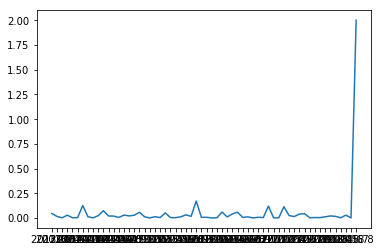

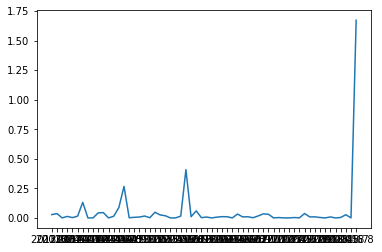

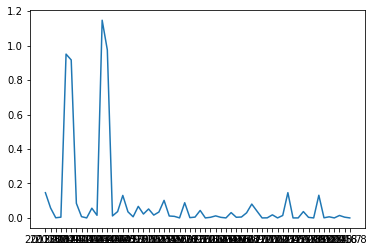

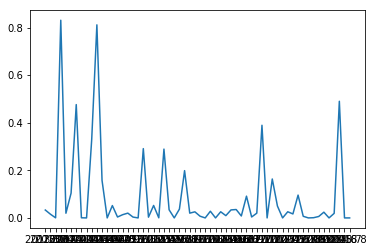

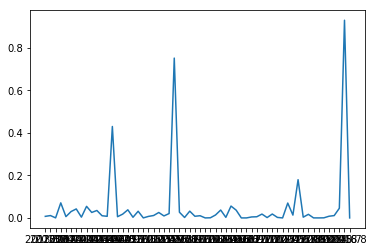

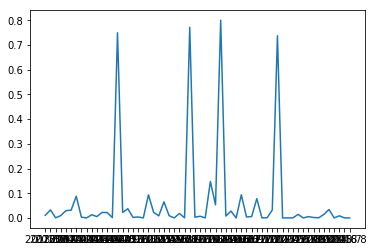

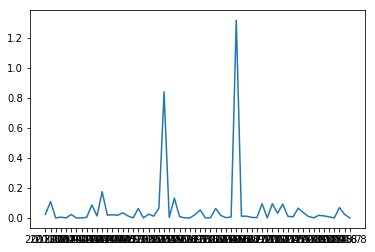

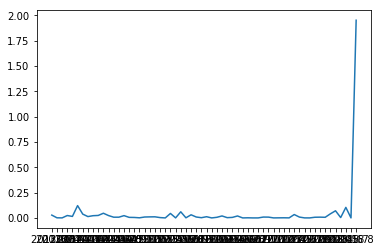

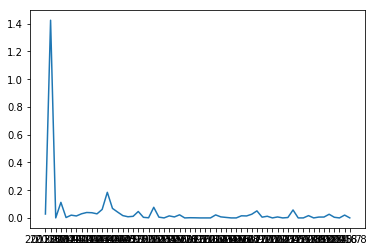

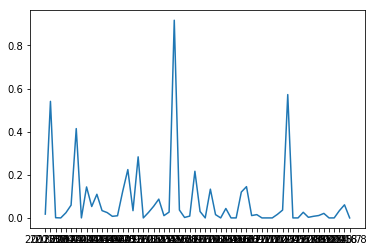

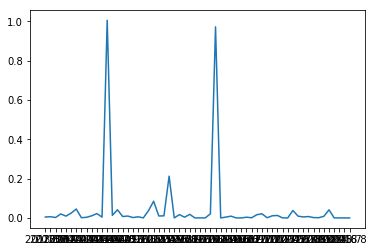

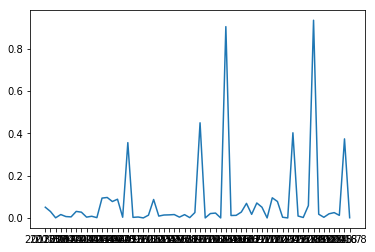

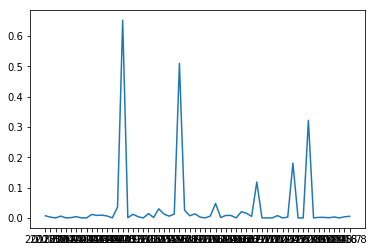

In [25]:
for col in range(40, 60):
    plt.figure()
    plt.plot(df_grouped_month[col])

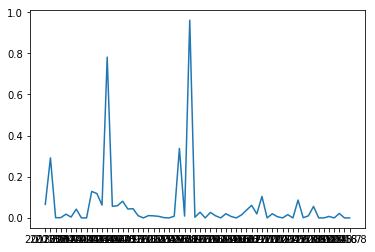

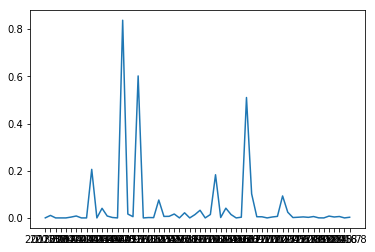

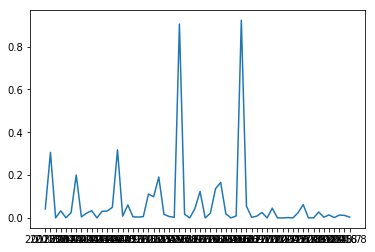

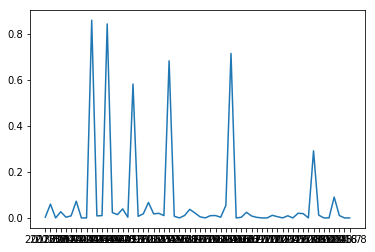

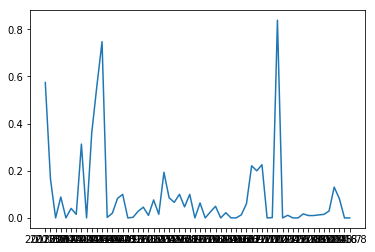

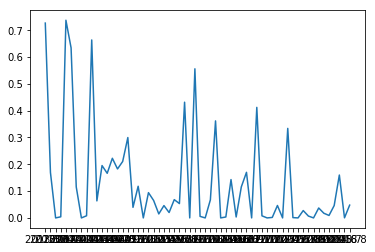

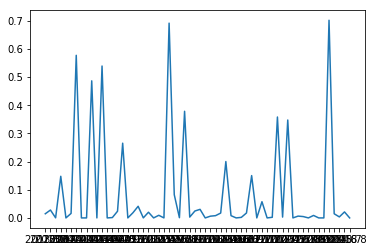

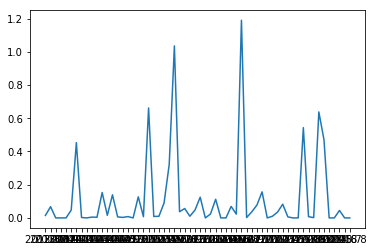

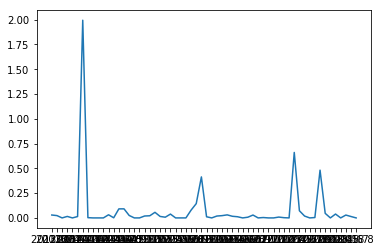

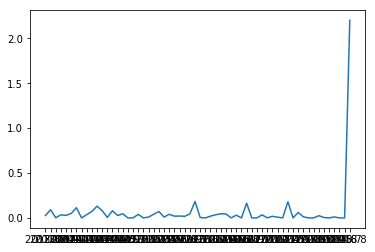

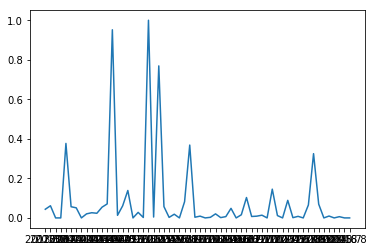

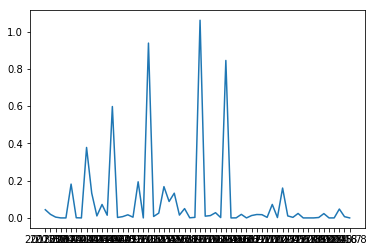

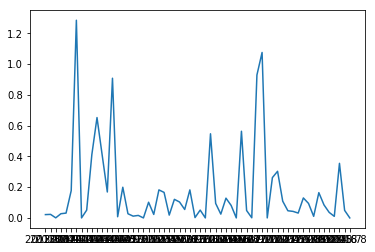

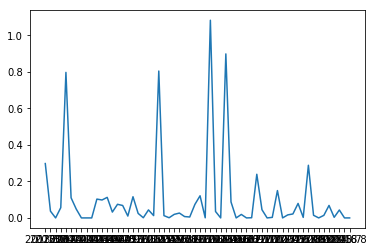

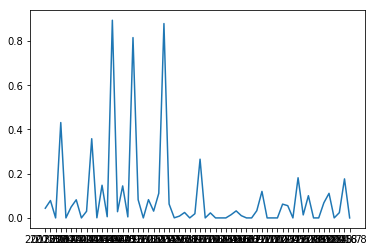

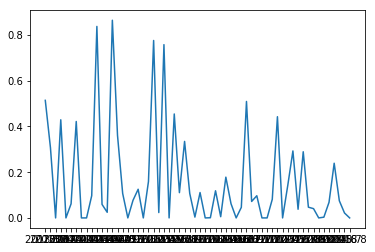

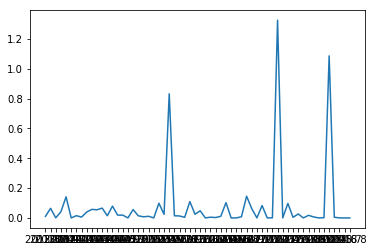

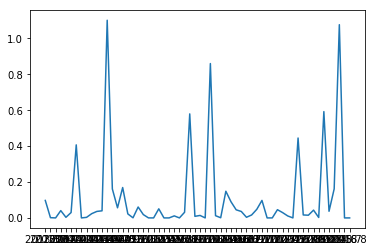

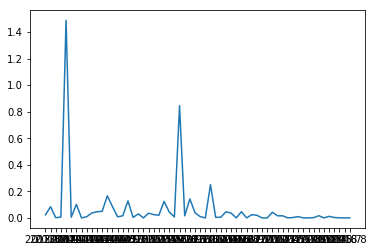

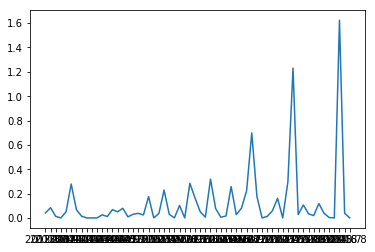

In [26]:
for col in range(60, 80):
    plt.figure()
    plt.plot(df_grouped_month[col])

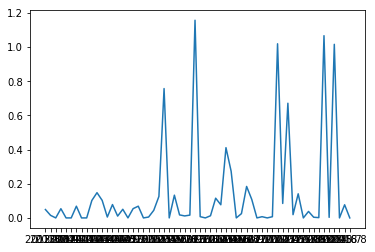

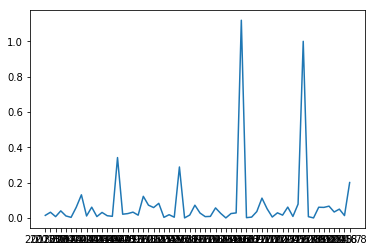

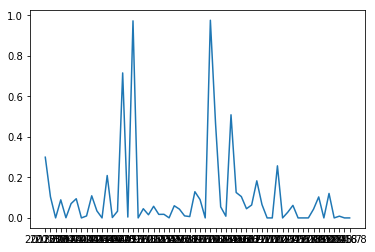

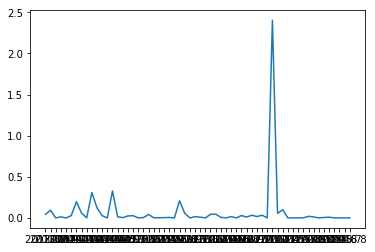

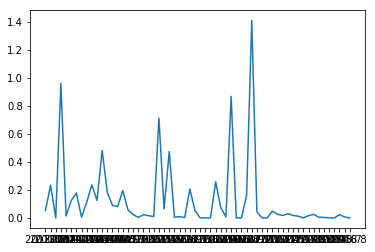

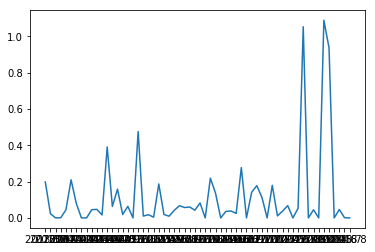

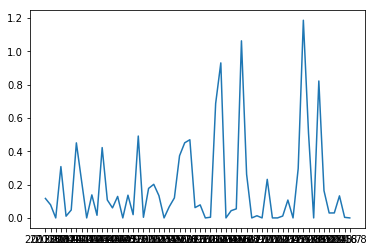

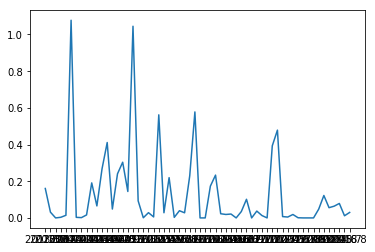

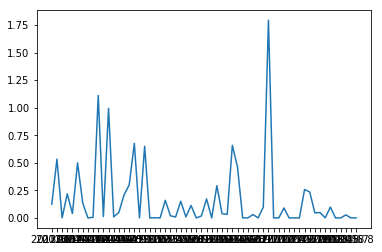

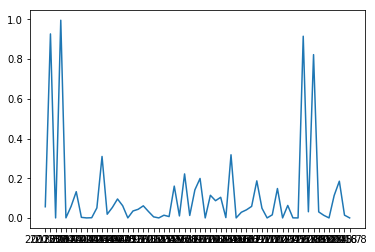

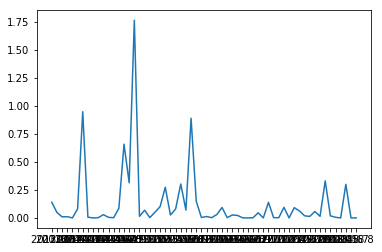

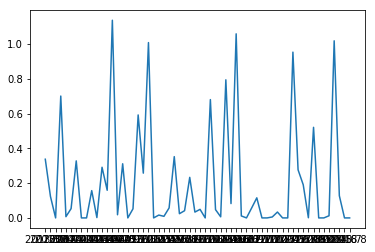

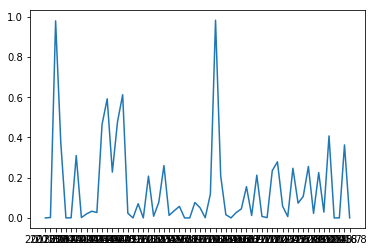

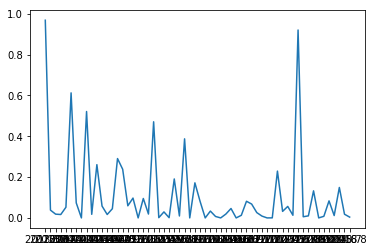

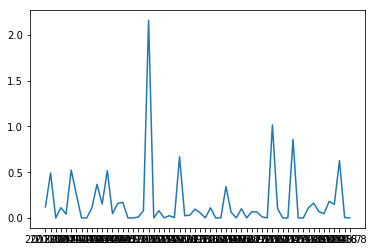

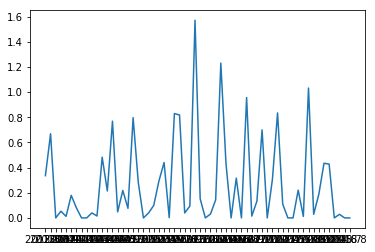

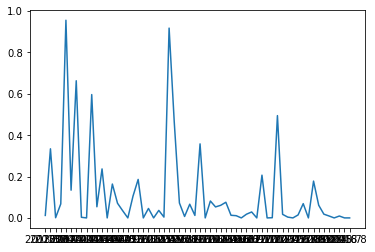

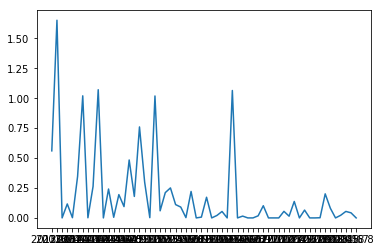

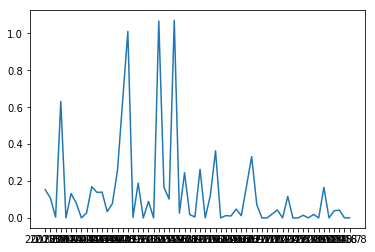

In [27]:
for col in range(80, 99):
    plt.figure()
    plt.plot(df_grouped_month[col])

### Evaluate Document Details for Consistent and New Importance Topics and Output for Visualization

In [28]:
df = df_articles_topics[df_articles_topics[40] > 0.5]
df['title']

4      Sika Automotive Receives Product Leadership Award
383    Sika Automotive Receives Product Leadership Award
Name: title, dtype: object

In [29]:
df['date']

4     2018-08-21
383   2018-08-21
Name: date, dtype: datetime64[ns]

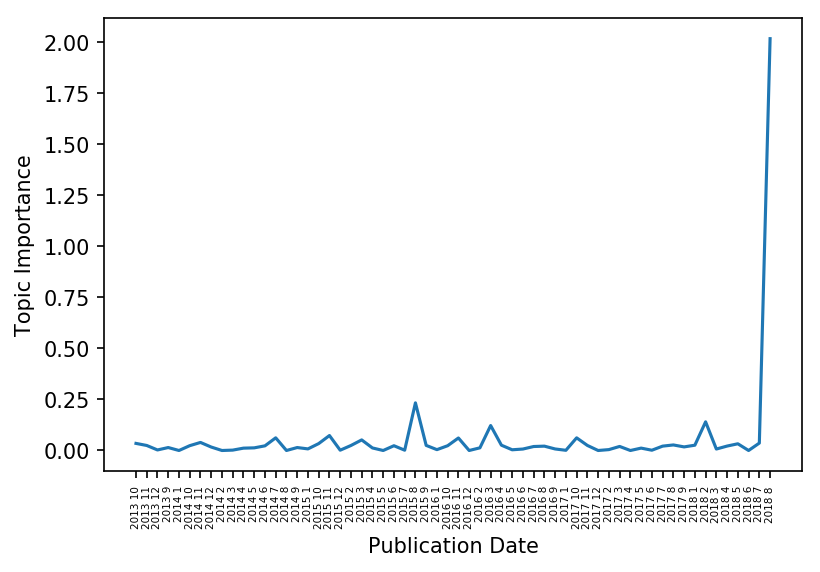

In [30]:
plt.figure(dpi = 150)
plt.plot(df_grouped_month[40])
plt.xlabel('Publication Date')
plt.ylabel('Topic Importance')
plt.xticks(rotation=90,size=5);

In [31]:
df_sika = df_grouped_month[40]
df_sika = df_sika.reset_index()

In [32]:
df_sika.columns = ['date', 'importance']
df_sika['date'] = pd.to_datetime(df_sika['date'],infer_datetime_format=True)

/Users/ericwk/anaconda/lib/python3.6/site-packages/dateutil/parser/__init__.py:46: DeprecationWarning: _timelex is a private class and may break without warning, it will be moved and or renamed in future versions.
  warnings.warn(msg, DeprecationWarning)


In [33]:
writer = pd.ExcelWriter('sika.xlsx')
df_sika.to_excel(writer,'Sheet1')
writer.save()

In [34]:
df2 = df_articles_topics[df_articles_topics[8] > 0.3]
pd.options.display.max_colwidth=100
df2['title']

12                                                                    UV-Curable Ink Applications Increase
96                    UV/Vis Energy-Cure Adhesives and Sealants: Industry Trends, Chemistry, and Packaging
123        What technologies are involved in making adhesives that fluoresce under ultraviolet (UV) light?
281    Can we speed up curing of an UV adhesive/sealant by using a full-spectrum bulb from the hardware...
Name: title, dtype: object

In [35]:
df2['date']

12    2016-02-01
96    2014-11-01
123   2017-11-01
281   2015-04-01
Name: date, dtype: datetime64[ns]

In [36]:
df_uv = df_grouped_month[8]
df_uv = df_uv.reset_index()

In [37]:
df_uv.columns = ['date', 'importance']
df_uv['date'] = pd.to_datetime(df_uv['date'],infer_datetime_format=True)
df_uv.head()

/Users/ericwk/anaconda/lib/python3.6/site-packages/dateutil/parser/__init__.py:46: DeprecationWarning: _timelex is a private class and may break without warning, it will be moved and or renamed in future versions.
  warnings.warn(msg, DeprecationWarning)


,date,importance
0,2013-10-01,0.250266
1,2013-11-01,0.033259
2,2013-12-01,0.000000
3,2013-09-01,0.005981
4,2014-01-01,0.000201


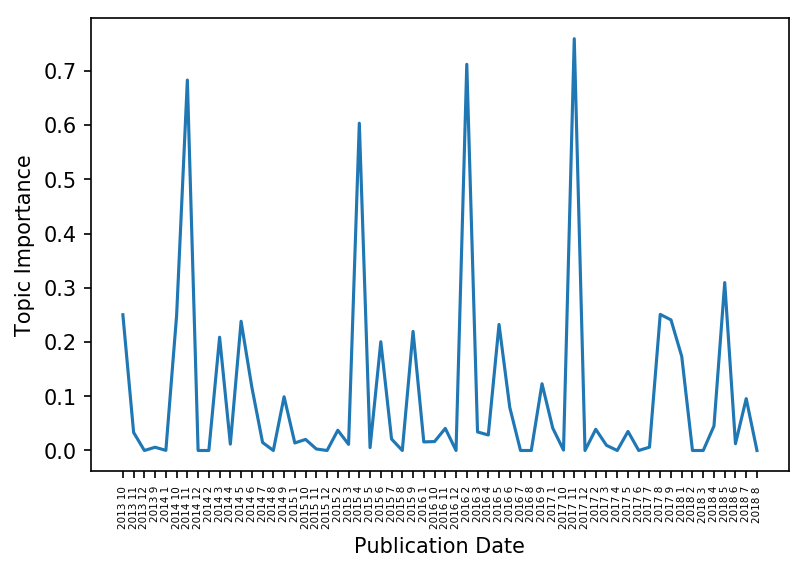

In [38]:
plt.figure(dpi = 150)
plt.plot(df_grouped_month[8])
plt.xlabel('Publication Date')
plt.ylabel('Topic Importance')
plt.xticks(rotation=90,size=5);

In [39]:
writer = pd.ExcelWriter('uv.xlsx')
df_uv.to_excel(writer,'Sheet1')
writer.save()

### Output multiple topics for visualization

In [48]:
df_multiple = df_grouped_month[[20, 74, 8, 40]]
df_multiple = df_multiple.reset_index()
df_multiple.columns = ['date', 'topic_1', 'topic_2', 'topic_3', 'topic_4']
df_multiple['date'] = pd.to_datetime(df_multiple['date'],infer_datetime_format=True)
df_multiple.head()

/Users/ericwk/anaconda/lib/python3.6/site-packages/dateutil/parser/__init__.py:46: DeprecationWarning: _timelex is a private class and may break without warning, it will be moved and or renamed in future versions.
  warnings.warn(msg, DeprecationWarning)


,date,topic_1,topic_2,topic_3,topic_4
0,2013-10-01,0.000115,0.043838,0.250266,0.034756
1,2013-11-01,0.000244,0.078620,0.033259,0.024581
2,2013-12-01,0.000014,0.000000,0.000000,0.002621
3,2013-09-01,0.000000,0.431069,0.005981,0.014467
4,2014-01-01,0.000157,0.000000,0.000201,0.000000


In [49]:
writer = pd.ExcelWriter('multiple.xlsx')
df_multiple.to_excel(writer,'Sheet1')
writer.save()